# Supervised Learning Project: Black Friday
This project was completed for a competition held on http://datahack.analyticsvidhya.com/contest/black-friday-data-hack
# Problem Statement
The challenge is to predict purchase prices of different products purchased by customers based on historical purchase data. The dataset contains features like User_ID, Product_ID, Gender, Age, Occupation, City_Category, Stay_In_Current_City_Years, Marital_Status, Product Category (1, 2, 3), and the target/independent feature 'Purchase'. This is a regression problem.

# Exploratory Analysis
First import the important libraries for analysis

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import percentile
import seaborn as sns

# Load the dataset
train = pd.read_csv('train/train.csv')
test = pd.read_csv('train/test.csv')

# Display the first 10 records
train.head(10)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969
5,1000003,P00193542,M,26-35,15,A,3,0,1,2.0,NaN,15227
6,1000004,P00184942,M,46-50,7,B,2,1,1,8.0,17.0,19215
7,1000004,P00346142,M,46-50,7,B,2,1,1,15.0,NaN,15854
8,1000004,P0097242,M,46-50,7,B,2,1,1,16.0,NaN,15686
9,1000005,P00274942,M,26-35,20,A,1,1,8,NaN,NaN,7871


Checking the dataset for any missing values

In [6]:
train.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

Here, Product_Category_2 and Product_Category_3 have missing values. But, I'm not going to use these features in my final model, so I'm not going to fix the missing values.

In [7]:
# Drop Product_Category_2 & Product_Category_3
train.drop(['Product_Category_2', 'Product_Category_3'], inplace = True, axis = 1)
test.drop(['Product_Category_2', 'Product_Category_3'], inplace = True, axis = 1)

Checking the data for outliers

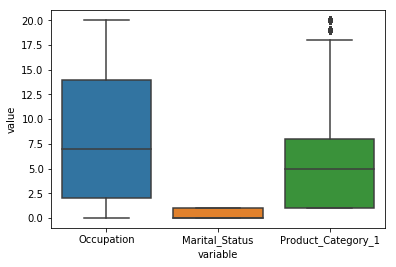

In [8]:
# Combining numerical features
temp_train = train[['Occupation', 'Marital_Status', 'Product_Category_1']]
sns.boxplot(x="variable", y="value", data=pd.melt(temp_train))

I checked the outliers on numeric features. Occupation and Marital_Status don't have any outliers. But seems like, we have detected outliers in Product_Category_1. So, we're going to fix it.

In [11]:
# Outliers detected, fix them
prod_cat = train.loc[:, train.columns == 'Product_Category_1']
# Computing Percentiles
q25, q75 = percentile(prod_cat, 25), percentile(prod_cat, 75)
iqr =q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
    
# filtering values based on computed percentiles
prod_cat = prod_cat.apply(lambda x: x[(x>=lower) & (x <= upper)], axis=0)
    
# Bringing all things together
prod_cat = pd.concat([train.loc[:,['User_ID', 'Product_ID', 'Gender', 'Age',
                                  'Occupation', 'City_Category', 'Stay_In_Current_City_Years',
                                  'Marital_Status', 'Purchase']], prod_cat], axis=1)

# Drop rows where Product_Category_1 have NaN values
train = prod_cat.dropna(subset=['Product_Category_1'])

Let's confirm that we have removed the outliers or not.

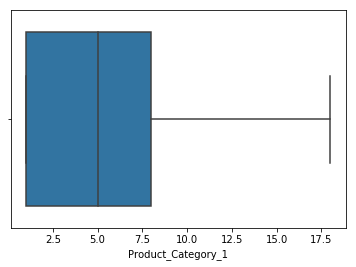

In [12]:
sns.boxplot(x=train['Product_Category_1'])

We have successfully fixed the outliers.

# Data Preprocessing
Let's do some feature engineering on some features.

If you take a look at the datasets, you will find 'Age' in range. To fix these Age bins, we will divide this column into two columns: Lower_Age and Upper_Age.

In [13]:
def handling_age(data):
    lower_age = []
    upper_age = []
    for i in data['Age']:
        if i != '55+':
            split_bin = i.split('-')
        else:
            split_bin = i.split('+')
            
        lower_age.append(int(split_bin[0]))
        if not split_bin[1]:
            upper_age.append(60) # We're going to set age 55+ to 60
        else:
            upper_age.append(int(split_bin[1]))
    return lower_age, upper_age

lower_age_train, upper_age_train = handling_age(train)
lower_age_test, upper_age_test = handling_age(test)

train['Lower_Age'], train['Upper_Age'] = lower_age_train, upper_age_train
test['Lower_Age'], test['Upper_Age'] = lower_age_test, upper_age_test

Let's remove some features.
Removing 'Age' feature, because we don't need it now.
Remove 'Stay_In_Current_City_Years'. Because I don't think, time of staying of a person in a city has anything to do with a person's expenditure.

In [14]:
train.drop(['Age', 'Stay_In_Current_City_Years'], inplace=True, axis=1)
test.drop(['Age', 'Stay_In_Current_City_Years'], inplace=True, axis=1)

Let's do encoding on categorical data.

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['User_ID'] = le.fit_transform(train['User_ID'])
test['User_ID'] = le.fit_transform(test['User_ID'])

# Encoding Gender
le_g = LabelEncoder()
train['Gender'] = le_g.fit_transform(train['Gender'])
test['Gender'] = le_g.fit_transform(test['Gender'])

# Encoding City_Category using get_dummies
def one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=True)
        df = pd.concat([df, dummies], axis=1)
    return df

train = one_hot(train, cols = ['City_Category'])
test = one_hot(test, cols = ['City_Category'])
# Removing City_Category
train.drop(['City_Category'], inplace=True, axis=1)
test.drop(['City_Category'], inplace=True, axis=1)

# Encoding Product_ID
# Here, Product_ID has high cardinality, so I'm not going to apply label or one hot encoding
# Istead, we will use Mean/Target Encoding.
# Thanks to olivier https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features for a beautiful function
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
   
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

train['Product_ID'], test['Product_ID'] = target_encode(train['Product_ID'], 
                         test['Product_ID'], 
                         target=train['Purchase'], 
                         min_samples_leaf=1,
                         smoothing=1,
                         noise_level=0)

Rearrange columns to make it look better.

In [20]:
# Rearranging columns
train = train[['User_ID', 'Product_ID', 'Gender', 'Lower_Age', 'Upper_Age',
            'Occupation', 'City_Category_B', 'City_Category_C', 'Marital_Status', 
            'Product_Category_1', 'Purchase']]
test = test[['User_ID', 'Product_ID', 'Gender', 'Lower_Age', 'Upper_Age',
            'Occupation', 'City_Category_B', 'City_Category_C', 'Marital_Status', 'Product_Category_1']]
train.head(5)

,User_ID,Product_ID,Gender,Lower_Age,Upper_Age,Occupation,City_Category_B,City_Category_C,Marital_Status,Product_Category_1,Purchase
0,0,11870.863436,0,0,17,10,0,0,0,3.0,8370
1,0,16304.030981,0,0,17,10,0,0,0,1.0,15200
2,0,1237.892157,0,0,17,10,0,0,0,12.0,1422
3,0,1455.140762,0,0,17,10,0,0,0,12.0,1057
4,1,7692.763547,1,55,60,16,0,1,0,8.0,7969


Assign target feature 'Purchase' to a variable, and remove the feature from the training dataset.

In [21]:
y = train['Purchase']
train.drop(['Purchase'], inplace=True, axis=1)

As we can see now, the features are not at all on the same scale. We definitely need to scale them.

In [22]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

train[['User_ID', 'Product_ID', 'Gender', 'Lower_Age', 'Upper_Age',
            'Occupation', 'City_Category_B', 'City_Category_C', 'Marital_Status', 
            'Product_Category_1']] = sc.fit_transform(train[['User_ID', 'Product_ID', 'Gender', 'Lower_Age', 'Upper_Age',
            'Occupation', 'City_Category_B', 'City_Category_C', 'Marital_Status', 
            'Product_Category_1']])

test[['User_ID', 'Product_ID', 'Gender', 'Lower_Age', 'Upper_Age',
            'Occupation', 'City_Category_B', 'City_Category_C', 'Marital_Status', 
            'Product_Category_1']] = sc.fit_transform(test[['User_ID', 'Product_ID', 'Gender', 'Lower_Age', 'Upper_Age',
            'Occupation', 'City_Category_B', 'City_Category_C', 'Marital_Status', 
            'Product_Category_1']])

C:\Users\Ubaid\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Ubaid\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Ubaid\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Ubaid\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# Modeling
I'm going to use XGBoost, because I tried other regression models, and XGBoost was the one which gave me the best results.

In [23]:
import xgboost as xgb
dtrain = xgb.DMatrix(train.values, label=y, missing=np.nan)

Because, this is a very large dataset and I don't have good CPU, so I performed parameter tuning on small dataset, got the following best parameters. I'm not sure, these are the best parameters.

In [24]:
param = {'objective': 'reg:linear', 'booster': 'gbtree', 'silent': 1,
		 'max_depth': 10, 'eta': 0.1, 'nthread': 4,
		 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 20,
		 'max_delta_step': 0, 'gamma': 0}
num_round = 690

seeds = [1, 12, 23, 28, 42] # Random Seeds
# Creating a prediction matrix with rows equal to total number of rows in test set.
# And equal to total number of columns as seeds length.
test_preds = np.zeros((len(test), len(seeds)))

In [ ]:
import sys
for run in range(len(seeds)):
	sys.stdout.write("\rXGB RUN:{}/{}".format(run+1, len(seeds)))
	sys.stdout.flush()
	param['seed'] = seeds[run]
	clf = xgb.train(param, dtrain, num_round)
	dtest = xgb.DMatrix(test.values, missing=np.nan)
	test_preds[:, run] = clf.predict(dtest)
    
test_preds = np.mean(test_preds, axis=1)

You can download the predicted data from here: https://drive.google.com/file/d/1OhLKaQxq9_yD9C5W7LSNTMPlutrAdH27/view

One thing I noticed, if I don't apply feature scaling, then I'm getting a good RMSE score of '2560'.
But after applying feature scaling, I'm getting bad RMSE score of '2508'.

You can see the results on the leaderboard: https://datahack.analyticsvidhya.com/contest/black-friday/lb

# Note
Seems like the dataset needs more feature engineering. May be dimensionality reduction could produce better results.